# Quick-look photometry & flux ratio calibration demo

Estimate the flux ratio of a point source in an HLC image based on aperture photometry in a 3x3 pixel box

In [1]:
import numpy as np
import os
import astropy.units as u
import astropy.io.fits as fits

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.origin'] = 'lower'

### File paths

In [3]:
raw_data_file_path = os.path.abspath('../../Data/HLC/HLC DATA')
cal_file_path = os.path.abspath('../../Data/HLC/HLC CAL')
proc_data_file_path = os.path.abspath('../../Data/HLC/HLC proc')

raw_coadd_fname = os.path.join(raw_data_file_path, "HLC_scistar_coadd_epoch01.fits")
rdi_coadd_fname = os.path.join(proc_data_file_path, 'HLC_scistar_RDI_rollcomb_seq.fits')
star_cal_fname = os.path.join(cal_file_path, "HLC_scistar_unocc_PSF_model.fits")
psf_peak_map_fname = os.path.join(cal_file_path, "OS6_HLC_PSF_peak_map.fits")

assert(os.path.exists(rdi_coadd_fname))
assert(os.path.exists(star_cal_fname))

### Misc. observation and data parameters

## IMPORTANT note: the total integration time assumed below (2 x 52800 sec) is appropriate for the tutorial HLC data set. The HLC observations for the official data challenge have 66000 sec per roll in each epoch. Therefore, to apply a similar analysis to the official data challenge images you would set tot_inttime to 2 x 66000 sec instead of 2 x 52800 sec.

In [4]:
pixscale = 21.08 * u.milliarcsecond
det_qe = 0.75 * u.electron / u.photon # effective QE of detector
pc_loss = 0.8 # photon counting coincidence losses
tot_inttime = 2 * 52800 * u.second # total integration time in one epoch with both rolls combined
print("The total science target integration time of each HLC epoch is {:.2f}".format(tot_inttime.to(u.hour)))

The total science target integration time of each HLC epoch is 29.33 h


## Load a co-added, post-processed HLC image

#### This image has the same flux units as the "raw" images: each pixel contains the number of photoelectrons collected over the total integration time.

In [5]:
rdi_coadd_img = fits.getdata(rdi_coadd_fname)[0]

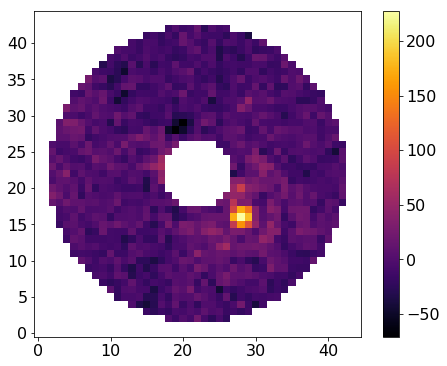

In [6]:
plt.figure(figsize=(8,6))
plt.imshow(rdi_coadd_img)
_ = plt.colorbar()

Peak col = 28, peak row = 16
Sum in 3 x 3 box = 1342.86 electron


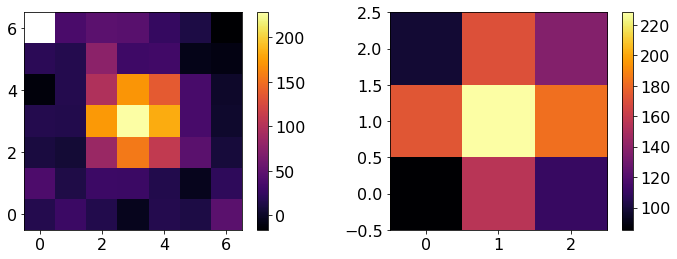

In [7]:
img_width = rdi_coadd_img.shape[0]
phot_box_width = 3

src_peak_row = np.nanargmax(np.ravel(rdi_coadd_img)) // img_width
src_peak_col = np.nanargmax(np.ravel(rdi_coadd_img)) % img_width

phot_box_sum = np.sum(rdi_coadd_img[src_peak_row - phot_box_width // 2 : 
                                    src_peak_row + phot_box_width // 2 + 1,
                                    src_peak_col - phot_box_width // 2 : 
                                    src_peak_col + phot_box_width // 2 + 1]) * u.electron

print("Peak col = {:d}, peak row = {:d}".format(src_peak_col, src_peak_row))
print("Sum in {:d} x {:d} box = {:.2f}".format(phot_box_width, phot_box_width, phot_box_sum))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 7
plt.imshow(rdi_coadd_img[src_peak_row - plot_box_width // 2 : 
                         src_peak_row + plot_box_width // 2 + 1,
                         src_peak_col - plot_box_width // 2 : 
                         src_peak_col + plot_box_width // 2 + 1])
_ = plt.colorbar()

plt.subplot(122)
plt.imshow(rdi_coadd_img[src_peak_row - phot_box_width // 2 : 
                         src_peak_row + phot_box_width // 2 + 1,
                         src_peak_col - phot_box_width // 2 : 
                         src_peak_col + phot_box_width // 2 + 1])
_ = plt.colorbar()

### Estimate the relative PSF attenuation due to the occulting mask

In [8]:
src_sep_pix = np.sqrt((src_peak_col - img_width // 2)**2 + (src_peak_row - img_width // 2)**2)
src_sep_mas = src_sep_pix * pixscale
print("Source angular separation {:.2f} pixels, {:.2f}".format(src_sep_pix, src_sep_mas))

Source angular separation 8.49 pixels, 178.87 marcsec


In [9]:
psf_peak_map = fits.getdata(psf_peak_map_fname)
psf_peak_map_hdr = fits.getheader(psf_peak_map_fname)
raw_coadd_hdr = fits.getheader(raw_coadd_fname)

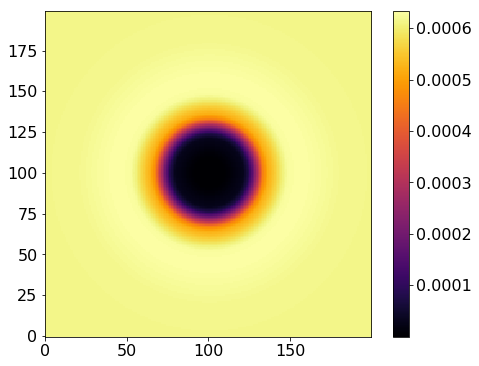

In [10]:
plt.figure(figsize=(8,6))
plt.imshow(psf_peak_map)
plt.colorbar()

#### To extract the value of this map most appropriate for the source location, you need to take into account the different pixel scale of the detector versus the PSF peak map array.

In [11]:
pixscale_ratio = raw_coadd_hdr['PIX_LD'] / psf_peak_map_hdr['PIXSIZE']
print(pixscale_ratio)

4.2000023908478346


In [12]:
peak_map_width = psf_peak_map.shape[0]

src_peak_map_col = (peak_map_width // 2 
                    + int(np.round((src_peak_col - img_width // 2)
                    * pixscale_ratio)))
src_peak_map_row = (peak_map_width // 2
                    + int(np.round((src_peak_row - img_width // 2)
                    * pixscale_ratio)))

print("Source position in peak map: {:}, {:}".format(src_peak_map_col, src_peak_map_row))

psf_atten = psf_peak_map[src_peak_map_row, src_peak_map_col] / np.max(psf_peak_map)
print("Relative PSF attenuation: {:.2f}".format(psf_atten))

Source position in peak map: 125, 75
Relative PSF attenuation: 0.80


### Estimate the background count rate by taking a box away from the source, but at a similar angular separation from the star

B.g. estimate = 1.495 electron
B.g.-subtracted aperture sum = 1329.406 electron


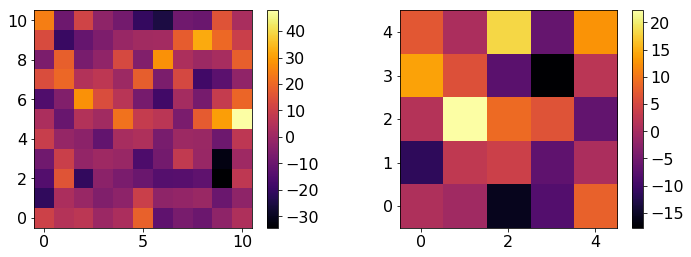

In [13]:
bg_samp_col = 11
bg_samp_row = 23
bg_box_width = 5
bg_est = np.median(rdi_coadd_img[bg_samp_row - bg_box_width//2 : 
                                 bg_samp_row + bg_box_width // 2 + 1,
                                 bg_samp_col - bg_box_width//2 : 
                                 bg_samp_col + bg_box_width // 2 + 1]) * u.electron

phot_box_sum_bgsub = phot_box_sum - bg_est * (phot_box_width * phot_box_width)

print("B.g. estimate = {:.3f}".format(bg_est))
print("B.g.-subtracted aperture sum = {:.3f}".format(phot_box_sum_bgsub))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 10
plt.imshow(rdi_coadd_img[bg_samp_row - plot_box_width//2 : 
                         bg_samp_row + plot_box_width // 2 + 1,
                         bg_samp_col - plot_box_width//2 : 
                         bg_samp_col + plot_box_width // 2 + 1])
_ = plt.colorbar()

plt.subplot(122)
plt.imshow(rdi_coadd_img[bg_samp_row - bg_box_width//2 : 
                         bg_samp_row + bg_box_width // 2 + 1,
                         bg_samp_col - bg_box_width//2 : 
                         bg_samp_col + bg_box_width // 2 + 1])
_ = plt.colorbar()

### Measure the star PSF model count rate in the same 3x3 box

25 25
Peak col = 25, peak row = 25
Star PSF photon count rate in 3 x 3 box = 5955766.26 ph / s


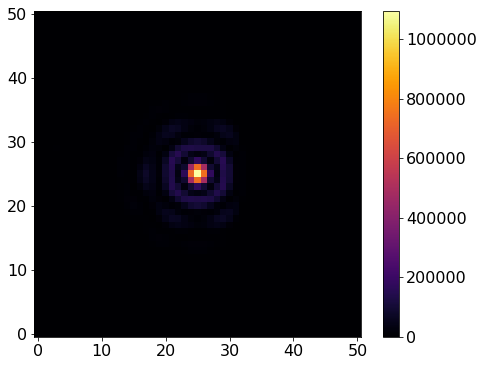

In [14]:
star_cal_img = fits.getdata(star_cal_fname)
star_cal_img_width = star_cal_img.shape[0]

star_peak_row = np.nanargmax(np.ravel(star_cal_img)) // star_cal_img_width
star_peak_col = np.nanargmax(np.ravel(star_cal_img)) % star_cal_img_width
print(star_peak_col, star_peak_row)

star_phot_box_sum = (np.sum(star_cal_img[star_peak_row - phot_box_width//2 : 
                                         star_peak_row + phot_box_width // 2 + 1,
                                         star_peak_col - phot_box_width//2 : 
                                         star_peak_col + phot_box_width // 2 + 1])
                     * u.photon / u.second)

print("Peak col = {:d}, peak row = {:d}".format(star_peak_col, star_peak_row))
print("Star PSF photon count rate in {:d} x {:d} box = {:.2f}".format(
      phot_box_width, phot_box_width, star_phot_box_sum))

plt.figure(figsize=(8, 6))
plt.imshow(star_cal_img)
plt.colorbar()

### To convert the integrated photoelectrons measured from the planet photometry to planet-to-star flux ratio, use the star PSF model count rate and take into account the integration time and the signal loss factors (QE, photon counting losses, occculting mask transmission).

In [15]:
planet_phot_box_sum = (phot_box_sum / (det_qe * pc_loss * psf_atten)) / tot_inttime
print("Planet PSF photon count rate in {:d} x {:d} box = {:.2E}".format(
      phot_box_width, phot_box_width, planet_phot_box_sum))

planet_flux_ratio = planet_phot_box_sum / star_phot_box_sum
print("Measured planet flux ratio = {:.3E}".format(planet_flux_ratio))

Planet PSF photon count rate in 3 x 3 box = 2.64E-02 ph / s
Measured planet flux ratio = 4.441E-09


### Compare against "truth"

In [16]:
true_flux_ratio = 4.17E-9 # taken from scene simulation inputs
error_frac = (planet_flux_ratio - true_flux_ratio) / true_flux_ratio
print("Measured flux ratio = {:.2E}\nTrue flux ratio = {:.2E}\nRelative error = {:.1f}%".format(
      planet_flux_ratio, true_flux_ratio, 100 * error_frac))

Measured flux ratio = 4.44E-09
True flux ratio = 4.17E-09
Relative error = 6.5%
